In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import root, minimize, fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from scipy.sparse import diags
from scipy.linalg import solve
from scipy.interpolate import interp1d

Equation to solve (assume constant $\rho, B_z, B_{\phi}, k_z, k_{\phi}, q=3/2, D$ represents $\partial_r$ and $k^2 = k_z^2 + k_{\phi}^2$):
$\tau(\rho - \frac{\mu^2}{\tau^2}) (D^2 - k^2) u - 2q\Omega_0 k_{\phi} \frac{\mu^2}{\tau^2} Du = \frac{2\Omega_0^2}{\tau} [k_z^2\rho (q - \frac{2\rho}{\rho - \mu^2/\tau^2}) + k_{\phi}^2 q^2 \frac{\mu^2}{\tau^2}] u$

Constraint at the interface:
$\Delta_s[\rho \tau D u - \mu^2 D(\frac{u}{\tau})] + k_{\phi}\Omega_0(q-2) \Delta_s(\rho u) + gk^2 (\frac{u}{\tau})_s \Delta_s(\rho) = 0$

### Apply shooting method to the MRTI equation

In [2]:
### helper functions
def tau(n, k1, vsh):
    return n + k1*vsh

def mu(k1, k2, B1, B2):
    return k1*B1 + k2*B2

def alpha_sq(n, k1, k2, vsh, B1, B2, rho):
    return rho*tau(n,k1,vsh)**2 - mu(k1,k2,B1,B2)**2

### coefficient of u"
def A(n, k1, k2, vsh, B1, B2, rho):
    return (tau(n,k1,vsh)*alpha_sq(n,k1,k2,vsh,B1,B2,rho))**2

### coefficient of u'
def B(n, k1, k2, vsh, B1, B2, q, Omega, rho):
    return 2*q*Omega*k1*tau(n,k1,vsh)*alpha_sq(n,k1,k2,vsh,B1,B2,rho) * mu(k1,k2,B1,B2)**2

### coefficient of u
def C(n, k1, k2, vsh, B1, B2, q, Omega, rho):
    tmp = 2*Omega**2 * (k2**2 * tau(n,k1,vsh)**2 * rho*(q*alpha_sq(n,k1,k2,vsh,B1,B2,rho) - 2*rho*tau(n,k1,vsh)**2) + alpha_sq(n,k1,k2,vsh,B1,B2,rho)*(k1*q*mu(k1,k2,B1,B2))**2)
    return A(n, k1, k2, vsh, B1, B2, rho) + tmp

In [4]:
### Parameters and initial conditions
r1 = np.linspace(0, 30, 3000)
r2 = np.linspace(-30, 0, 3000)
#initial_guess = np.zeros((2, r1.size), dtype=complex)
Omega = 5e-3
q = 3/2
params = [60, 10, q, Omega]
knowns1 = [0.022, 0.0032, 0.0036] # estimated params for background flow (need to change)
knowns2 = [0.0042, 0.0018, 0.014] # estimated params for bubble region (need to change)

In [5]:
### ODE system:
def ode(r, u, n):
    k1, k2, q, Omega = params
    rho, B1, B2 = knowns2
    vsh_r = -q*Omega*r
    return np.array([u[1], (B(n, k1, k2, vsh_r, B1, B2, q, Omega, rho)*u[1]+C(n, k1, k2, vsh_r, B1, B2, q, Omega, rho)*u[0])/A(n, k1, k2, vsh_r, B1, B2, rho)])

### solve the ODE in each region for a given n
def solve_ode_for_n(prime, n):
    y0 = np.array([0+0*1j, prime+0*1j], dtype=complex)
    sol = solve_ivp(lambda r, u: ode(r, u, n), np.array([-30, 0]), 
                    y0, t_eval=np.linspace(-30, 0, 3000), method='RK45')
    return sol

### Function for root-finding
def objective(guess, n):
    prime = guess[0] + guess[1]*1j
    sol = solve_ode_for_n(prime, n)
    y1 = sol.y[0, -1]  # This is y(60)
    return np.abs(np.real(y1)-1e12 + np.imag(y1)-0)  # We want y(60) = 1

In [6]:
# Use root_scalar to find the correct initial condition y'(30)
sol_guess = minimize(objective, [0.01, 0.01], method='Nelder-Mead', args=(1+1j), tol=1e-3)
correct_guess = sol_guess.x
correct_prime = correct_guess[0] + correct_guess[1]*1j

# Solve the system with the correct initial condition
sol = solve_ode_for_n(correct_prime, 1+1j)

# Plot the solution
x = sol.t
solution = sol.y[0]

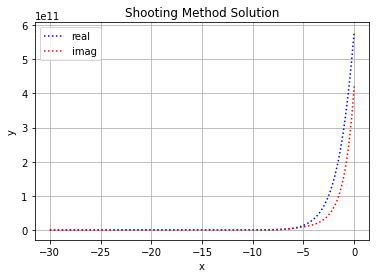

In [7]:
plt.plot(x, np.real(solution), 'b:', label='real')
plt.plot(x, np.imag(solution), 'r:', label='imag')
#plt.ylim([-2, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.title("Shooting Method Solution")
plt.legend()
plt.grid(True)
plt.show()

#### Finite Difference Method for complex non-autonomous ODE
Check Numerical Recipes Ch.17 on BVP

y"(t) + ny'(t) + t = 0 where y(t) is complex-valued and n=1+1j, y(0) = y(10) = 0

In [8]:
### parameters
tf = 10
t = np.linspace(0, tf, 501)
h = tf/500
n = 1+1j
tol = 1e-10

### trail solution
y = np.ones(len(t), dtype=complex)*10
yp = np.zeros(len(t), dtype=complex)
var = np.empty((y.size+yp.size,), dtype=y.dtype)
yerr = np.zeros(2*len(t))
var[0::2] = y
var[1::2] = yp

### construct the matrix
main_diag = np.zeros(2*len(t), dtype=complex)
upper_diag = np.ones(2*len(t)-1, dtype=complex)
lower_diag = -1*np.ones(2*len(t)-1, dtype=complex)

A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).toarray()
for i in range(A.shape[0]-1):
    if i%2 == 1:
        A[i, i+2] = -h
    if (i%2 == 0) and (i != 0):
        A[i, i+1] += h*n

### deal with boundary conditions
A[0,0] = 1
A[0,1] = 0
A[-1,-2] = 1

In [9]:
### iteratively update the solution by computing yerr which solves the matrix to make E_jk = 0
for i in range(10**3):
    var_old = var.copy()
    yerr_old = yerr.copy()
     
    y_old = var_old[0::2]
    #y_old[0] = var_old[1]
    yp_old = var_old[1::2]
    #yp_old[0] = var_old[0]
    
    ### calculate E_jk for the updated y and yp
    E1 = y_old[1:] - y_old[:-1] - h*yp_old[1:]
    E2 = yp_old[1:] - yp_old[:-1] + h*t[1:] + h*n*yp_old[1:]
    E = np.empty((E1.size + E2.size,), dtype=E1.dtype)
    E[0::2] = E1
    E[1::2] = E2
    E = -1*np.append(np.append(y_old[0], E), y_old[-1])
    
    ### solve for yerr
    yerr = solve(A, E)
    ### update the solution
    var += yerr
    if max(abs(yerr - yerr_old)) < tol:
        print(f"Converged after {i+1} iterations")
        break
else:
    print("Did not converge within the maximum number of iterations")

Converged after 3 iterations


In [10]:
### true solution by Wolfram Alpha
def y_true(x, j):
    # Calculate the numerator part
    term1 = x * np.exp((j + 1) * x) * (j * x + x - 2)
    term2 = (x - 10) * np.exp((j + 1) * (x + 10)) * (j * (x + 10) + x + 8)
    term3 = 20 * np.exp(10 * (j + 1)) * (5 * j + 4)
    
    numerator = np.exp(-(j + 1) * x) * (term1 - term2 - term3)
    
    # Calculate the denominator part
    denominator = 2 * (np.exp(10 * (j + 1)) - 1) * (j + 1)**2
    
    # Compute y(x)
    return numerator / denominator

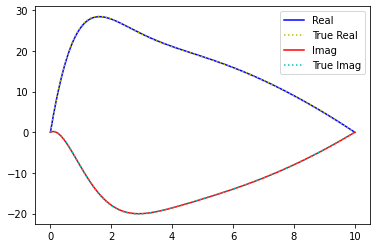

In [12]:
plt.plot(t, np.real(var[0::2]), 'b-', label='Real')
plt.plot(t, np.real(y_true(t, 1j)), 'y:', label='True Real')
plt.plot(t, np.imag(var[0::2]), 'r-', label='Imag')
plt.plot(t, np.imag(y_true(t, 1j)), 'c:', label='True Imag')
plt.legend()
plt.show()

### Apply FDM to MRTI problem

In [13]:
### helper functions
def tau(n, k1, vsh):
    return n + k1*vsh

def mu(k1, k2, B1, B2):
    return k1*B1 + k2*B2

def alpha_sq(n, k1, k2, vsh, B1, B2, rho):
    return rho*tau(n,k1,vsh)**2 - mu(k1,k2,B1,B2)**2

### coefficient of u"
def A(n, k1, k2, vsh, B1, B2, rho):
    return (tau(n,k1,vsh)*alpha_sq(n,k1,k2,vsh,B1,B2,rho))**2

### coefficient of u'
def B(n, k1, k2, vsh, B1, B2, q, Omega, rho):
    return 2*q*Omega*k1*tau(n,k1,vsh)*alpha_sq(n,k1,k2,vsh,B1,B2,rho) * mu(k1,k2,B1,B2)**2

### coefficient of u
def C(n, k1, k2, vsh, B1, B2, q, Omega, rho):
    tmp = 2*Omega**2 * (k2**2 * tau(n,k1,vsh)**2 * rho*(q*alpha_sq(n,k1,k2,vsh,B1,B2,rho) - 2*rho*tau(n,k1,vsh)**2) + alpha_sq(n,k1,k2,vsh,B1,B2,rho)*(k1*q*mu(k1,k2,B1,B2))**2)
    return A(n, k1, k2, vsh, B1, B2, rho) + tmp

In [24]:
def MRTI_relaxation_solver_left(n, k1, k2, N=300, tol=1e-6, max_iter=10**6, r_start=0, r_end=30,
                           q=3/2, Omega=5e-3, rho=0.022, B1=0.0032, B2=0.0036):
    r = np.linspace(r_start, r_end, N)
    h = (r_end - r_start) / (N - 1)
    vsh = -q*Omega*r
    
    u = np.sin(r, dtype=complex)
    up = np.cos(r, dtype=complex)
    var = np.empty((u.size+up.size,), dtype=u.dtype)
    uerr = np.zeros(2*len(r))
    var[0::2] = u
    var[1::2] = up
    
    # Construct the matrix
    main_diag = np.zeros(len(r)*2, dtype=complex)
    upper_diag = np.ones(len(r)*2-1, dtype=complex)
    lower_diag = -1*np.ones(len(r)*2-1, dtype=complex)

    M = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).toarray()
    for i in range(M.shape[0]-1):
        if i%2 == 1:
            M[i,i] = -h
        if (i%2 == 0) and (i != 0):
            M[i, i-1] += h*B(n, k1, k2, vsh[i//2 - 1], B1, B2, q, Omega, rho)/A(n, k1, k2, vsh[i//2 - 1], B1, B2, rho)
            M[i, i-2] = h*C(n, k1, k2, vsh[i//2 - 1], B1, B2, q, Omega, rho)/A(n, k1, k2, vsh[i//2 - 1], B1, B2, rho)

    # Boundary Conditions
    M[0,0] += 1
    M[0,1] *= 0
    M[-1,-2] += 2
    
    # Iterate using the relaxation method
    for iteration in range(max_iter):
        var_old = var.copy()
        uerr_old = uerr.copy()

        u_old = var_old[0::2]
        up_old = var_old[1::2]

        ### calculate E_jk for the updated u and up
        E1 = u_old[1:] - u_old[:-1] - h*up_old[:-1]
        E2 = up_old[1:] - up_old[:-1] + h*(B(n, k1, k2, vsh[:-1], B1, B2, q, Omega, rho)*up_old[:-1] + 
                                           C(n, k1, k2, vsh[:-1], B1, B2, q, Omega, rho)*u_old[:-1])/A(n, k1, k2, vsh[:-1], B1, B2, rho)
        E = np.empty((E1.size + E2.size,), dtype=E1.dtype)
        E[0::2] = E1
        E[1::2] = E2
        E = -1*np.append(np.append(u_old[0]-1, E), u_old[-1])

        ### solve for yerr
        uerr = solve(M, E)
        ### update the solution
        var += uerr
        if max(abs(uerr - uerr_old)) < tol:
            #print(f"Converged after {iteration+1} iterations")
            break
    else:
        print("Did not converge within the maximum number of iterations")
        
    return var[0::2], var[1::2], r, var[0::2][1:-1]/r[1:-1]

def MRTI_relaxation_solver_right(n, k1, k2, N=300, tol=1e-6, max_iter=10**6, r_start=-30, r_end=0,
                           q=3/2, Omega=5e-3, rho=0.0042, B1=0.0018, B2=0.014):
    r = np.linspace(r_start, r_end, N)
    h = (r_end - r_start) / (N - 1)
    vsh = -q*Omega*r
    
    u = np.sin(r, dtype=complex)
    up = np.cos(r, dtype=complex)
    var = np.empty((u.size+up.size,), dtype=u.dtype)
    uerr = np.zeros(2*len(r))
    var[0::2] = u
    var[1::2] = up
    
    # Construct the matrix
    main_diag = np.zeros(len(r)*2, dtype=complex)
    upper_diag = np.ones(len(r)*2-1, dtype=complex)
    lower_diag = -1*np.ones(len(r)*2-1, dtype=complex)

    M = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).toarray()
    for i in range(M.shape[0]-1):
        if i%2 == 1:
            M[i,i] = -h
        if (i%2 == 0) and (i != 0):
            M[i, i-1] += h*B(n, k1, k2, vsh[i//2 - 1], B1, B2, q, Omega, rho)/A(n, k1, k2, vsh[i//2 - 1], B1, B2, rho)
            M[i, i-2] = h*C(n, k1, k2, vsh[i//2 - 1], B1, B2, q, Omega, rho)/A(n, k1, k2, vsh[i//2 - 1], B1, B2, rho)

    # Boundary Conditions
    M[0,0] += 1
    M[0,1] *= 0
    M[-1,-2] += 2
    
    # Iterate using the relaxation method
    for iteration in range(max_iter):
        var_old = var.copy()
        uerr_old = uerr.copy()

        u_old = var_old[0::2]
        up_old = var_old[1::2]

        ### calculate E_jk for the updated u and up
        E1 = u_old[1:] - u_old[:-1] - h*up_old[:-1]
        E2 = up_old[1:] - up_old[:-1] + h*(B(n, k1, k2, vsh[:-1], B1, B2, q, Omega, rho)*up_old[:-1] + 
                                           C(n, k1, k2, vsh[:-1], B1, B2, q, Omega, rho)*u_old[:-1])/A(n, k1, k2, vsh[:-1], B1, B2, rho)
        E = np.empty((E1.size + E2.size,), dtype=E1.dtype)
        E[0::2] = E1
        E[1::2] = E2
        E = -1*np.append(np.append(u_old[0], E), u_old[-1]-1)

        ### solve for yerr
        uerr = solve(M, E)
        ### update the solution
        var += uerr
        if max(abs(uerr - uerr_old)) < tol:
            #print(f"Converged after {iteration+1} iterations")
            break
    else:
        print("Did not converge within the maximum number of iterations")
        
    return var[0::2], var[1::2], r, var[0::2][1:-1]/r[1:-1]

In [25]:
u_left, up_left, r_left, utau_left = MRTI_relaxation_solver_left(1.0+3.0j, 60, 10)
u_right, up_right, r_right, utau_right = MRTI_relaxation_solver_right(1.0+3.0j, 60, 10)

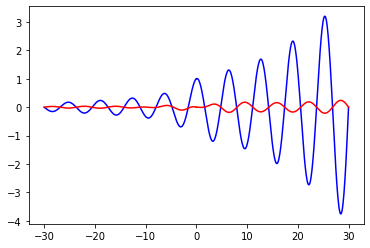

In [26]:
plt.plot(r_left, np.real(u_left), 'b-')
plt.plot(r_right, np.real(u_right), 'b-')
plt.plot(r_left, np.imag(u_left), 'r-')
plt.plot(r_right, np.imag(u_right), 'r-')
plt.show()

Per discussion with Boris, this looks like the Airy function. So we tried some perturbation to the Airy function as trail solution but failed.

In [27]:
left = np.gradient(utau_left, r_left[1:-1])
right = np.gradient(utau_right, r_right[1:-1])

In [28]:
#### Use FDM to solve the constraint
def nonlinear_constraint(n, k1, k2, u_left, u_right, up_left, up_right, left, right, 
                        rho1=0.022, rho2=0.0042, bphi1=0.0032, bz1=0.0036, 
                         bphi2=0.0018, bz2=0.014, q=3/2, Omega=5e-3):
    ksq = k1**2 + k2**2
    mu1 = k1*bphi1 + k2*bz1
    mu2 = k1*bphi2 + k2*bz2
    
    tmp1 = rho1*n*up_left[-2] - mu1**2*(left[-2]) - rho2*n*up_right[2] + mu2**2*(right[2])
    tmp2 = k1*Omega*(q-2)*(rho1*u_left[-2] - rho2*u_right[2]) - 0.00016*ksq/n*(rho1 - rho2)
    
    answer = tmp1 + tmp2
    
    #print('con:', np.abs(tmp1 + tmp2))
    ### or just np.real(answer) ?
    return np.abs(answer)

In [29]:
# Find n that minimizes the constraint
def func_to_min(n_guess, k1, k2):
    n = n_guess[0] + n_guess[1]*1j
    u_left, up_left, r_left, utau_left = MRTI_relaxation_solver_left(n, k1, k2)
    u_right, up_right, r_right, utau_right = MRTI_relaxation_solver_right(n, k1, k2)
    left = np.gradient(utau_left, r_left[1:-1])
    right = np.gradient(utau_right, r_right[1:-1])
    return nonlinear_constraint(n, k1, k2, u_left, u_right, up_left, up_right, left, right)

# Minimize
k1, k2 = 60, 10
n_sol = minimize(func_to_min, [0, 1], args=(k1, k2), method='BFGS', options={'maxiter': 1000, 'disp': True},
                tol=1e-10)
#n_sol = root(func_to_min, [10, 1], args=(k1, k2), tol=1e-10, method='df-sane')
n_final_sep = n_sol.x
n_final = n_final_sep[0] + n_final_sep[1]*1j

u_left, up_left, r_left, utau_left = MRTI_relaxation_solver_left(n_final, k1, k2)
u_right, up_right, r_right, utau_right = MRTI_relaxation_solver_right(n_final, k1, k2)
print('n final:', n_final)
print()

         Current function value: 0.000000
         Iterations: 29
         Function evaluations: 195
         Gradient evaluations: 61
n final: (-0.5788197553419869-0.3500437876863581j)



But this depends heavily on the initial guess and it takes ~ 1min clock time even for a sparse grid:

For initial guess [-10, 10], we end up with n = [0.10277, 0.39509]

For initial guess [0, 1], we end up with n = [-0.57882, -0.35004]

In [30]:
### do some quick check on the value by evaluating on a grid of n
nre = np.linspace(-10, 10, 10)
nim = np.linspace(-10, 10, 10)
X, Y = np.meshgrid(nre, nim)
con = np.zeros(X.shape)
for i in range(len(nre)):
    for j in range(len(nim)):
        n = nre[i] + 1j*nim[j]
        u_left, up_left, r_left, utau_left = MRTI_relaxation_solver_left(n, k1, k2)
        u_right, up_right, r_right, utau_right = MRTI_relaxation_solver_right(n, k1, k2)
        left = np.gradient(utau_left, r_left[1:-1])
        right = np.gradient(utau_right, r_right[1:-1])
        con[i, j] = nonlinear_constraint(n, k1, k2, u_left, u_right, up_left, up_right, left, right)

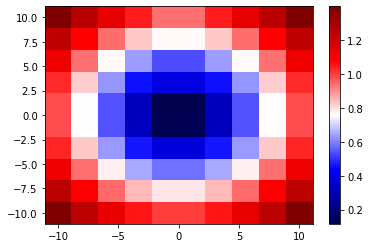

In [31]:
plt.pcolormesh(X, Y, con, cmap='seismic')
plt.colorbar()
plt.show()

This method also depends on the choice of grid, as the following image shows. But there might be a sign of convergence, which need to be checked further. I also tried multi-grid search, but it took too long even for a single calculation.

In [35]:
var_300, up_right, r_right, utau_right = MRTI_relaxation_solver_right(1.0+3.0j, 60, 10)
var_1000, up_right, r_right, utau_right = MRTI_relaxation_solver_right(1.0+3.0j, 60, 10, N=1000)
var_3000, up_right, r_right, utau_right = MRTI_relaxation_solver_right(1.0+3.0j, 60, 10, N=3000)

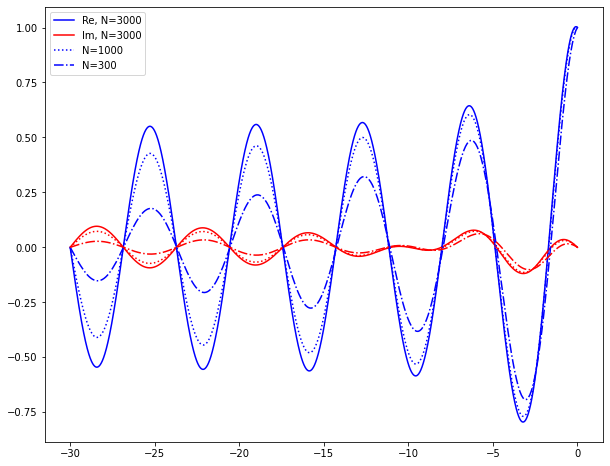

In [38]:
plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-30, 0, 3000), np.real(var_3000), 'b-', label='Re, N=3000')
plt.plot(np.linspace(-30, 0, 3000), np.imag(var_3000), 'r-', label='Im, N=3000')
plt.plot(np.linspace(-30, 0, 1000), np.real(var_1000), 'b:', label='N=1000')
plt.plot(np.linspace(-30, 0, 1000), np.imag(var_1000), 'r:')
plt.plot(np.linspace(-30, 0, 300), np.real(var_300), 'b', ls='-.', label='N=300')
plt.plot(np.linspace(-30, 0, 300), np.imag(var_300), 'r', ls='-.')
plt.legend()
#plt.savefig('figures/relaxation_demo.png', dpi=300)
plt.show()